# Split conformal prediction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import portion as P
from time import time
from tqdm import tqdm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
poly = PolynomialFeatures(4)

Data generating (see Zaffran's course on conformal prediction)

$$
X\sim Beta(6,3), \quad Y|X \sim \cos(X) + (1 - \cos(X))\mathcal{N}(0, 0.5)
$$

In [3]:
def sample_data(n):
    "Sample n data points from the given distribution"

    X = sp.stats.beta.rvs(a=6,b=3,loc=0,scale=6,size=n)

    ## Heteroscedastic model
    sigma = 0.5
    y = np.cos(X) + (1-np.cos(X))*sigma*np.random.normal(size=n)
    return X, y

In [4]:
def set_style():
    plt.rcParams["text.usetex"] = True
    font = {"family": "normal", "weight": "bold", "size": 22}
    plt.rc("font", **font)
    
set_style()

## Sample data

In [5]:
def sample_data_for_me(sample_size):
    # input_points, output_points = make_regression(sample_size + 1)
    input_points, output_points = sample_data(sample_size + 1)
    input_points = input_points.reshape(-1, 1)
    output_points = output_points.reshape(-1, 1)


    train_input_points = input_points[:-1, :]
    test_input_point = input_points[-1, :].reshape(1, -1)
    train_output_points = output_points[:-1, :]
    test_output_point = output_points[-1, :].reshape(1, -1)
    return train_input_points, train_output_points, test_input_point, test_output_point

In [6]:
class myRidge:
    def __init__(self, lam=0.5):
        self.lam = lam
        pass

    def fit(self, input_points, output_points):
        # For polynomial regression
        input_points = poly.fit_transform(input_points)

        weight, _, _, _ = np.linalg.lstsq(
            (input_points.T @ input_points) / input_points.shape[0]
            + 2 * self.lam * np.eye(output_points.shape[1]),
            input_points.T @ output_points / input_points.shape[0],
        ) 
        self.weight = weight

    def predict(self,input_points):
        input_points = poly.fit_transform(input_points)
        return input_points @ self.weight

In [7]:
sample_size = 200
train_input_points, train_output_points, test_input_point, test_output_point = (
    sample_data_for_me(sample_size)
)

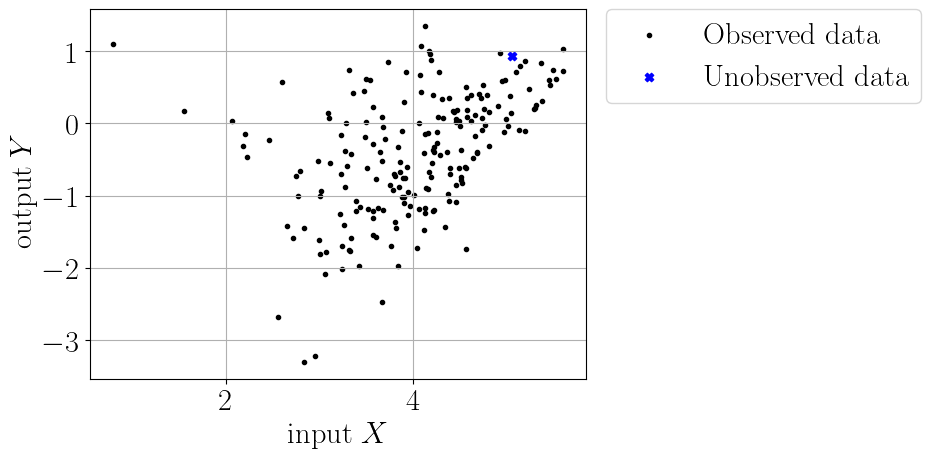

In [8]:
fig, ax = plt.subplots()
ax.scatter(train_input_points, train_output_points, label="Observed data", marker=".", color="k")
ax.scatter(test_input_point, test_output_point, label = "Unobserved data", marker="X", color="blue")
ax.set_ylabel(r"output $Y$")
ax.set_xlabel(r"input $X$")
ax.grid("on")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

## Non-conformity scores

In [9]:
# Split the train data set into
# a proper training data set (50 %) and 
# a calibration data set (50 %)
# (Hint: use sklearn)

proper_train_input_points, calibration_input_points, proper_train_output_points, calibration_output_points = train_test_split(
    train_input_points, train_output_points, train_size=0.5
)

In [10]:
# Train a predictor using the proper training data set
predictor = myRidge()
predictor.fit(
    proper_train_input_points, proper_train_output_points
)

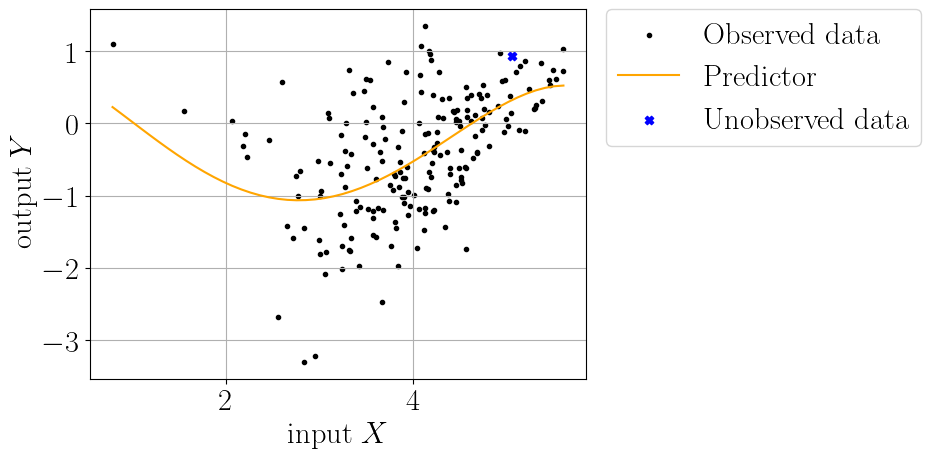

In [11]:
x_min = np.min(train_input_points)
x_max = np.max(train_input_points)
x_vals = np.linspace(x_min, x_max).reshape(-1, 1)


fig, ax = plt.subplots()
ax.scatter(train_input_points, train_output_points, label="Observed data", marker=".", color="k")
ax.plot(
    x_vals, predictor.predict(x_vals),
    label = "Predictor", color = "orange"
)
ax.scatter(test_input_point, test_output_point, label = "Unobserved data", marker="X", color="blue")
ax.set_ylabel(r"output $Y$")
ax.set_xlabel(r"input $X$")
ax.grid("on")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

In [12]:
# Compute non-conformity scores using the calibration data set
non_conformity_scores = np.abs(
    calibration_output_points - predictor.predict(calibration_input_points)
)

## Split conformal prediction interval

In [13]:
# Compute the quantile the non-conformity scores
confidence_control_level = 0.1
calibration_size = calibration_input_points.shape[0]
quantile_level = np.ceil((calibration_size + 1) * (1 - confidence_control_level)) / calibration_size
quantile_value = np.quantile(non_conformity_scores.flatten(), quantile_level, method="higher")

In [14]:
# Compute Split conformal prediction region
# by replacing upper and lower
# with the right values

lower = predictor.predict(test_input_point).item() - quantile_value
upper = predictor.predict(test_input_point).item() + quantile_value
prediction_region = P.closed(lower, upper)


In [15]:
def draw_interval(ax, ystart, ystop, x, color):
    ax.vlines(x, ystart, ystop, color, lw=4, alpha = 0.5, label="Prediction interval")
    ax.hlines(ystart, x+0.1, x-0.1, color, lw=1, alpha = 0.5)
    ax.hlines(ystop, x+0.1, x-0.1, color, lw=1, alpha = 0.5)
    return

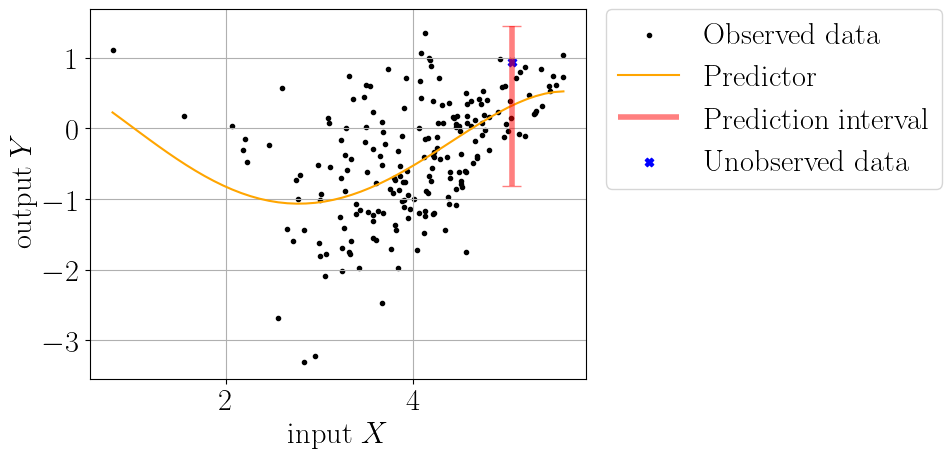

In [16]:
fig, ax = plt.subplots()
ax.scatter(train_input_points, train_output_points, label="Observed data", marker=".", color="k")
ax.plot(
    x_vals, predictor.predict(x_vals),
    label = "Predictor", color = "orange"
)
draw_interval(ax, prediction_region.lower, prediction_region.upper, test_input_point.item(), "red")
ax.scatter(test_input_point, test_output_point, label = "Unobserved data", marker="X", color="blue")
ax.set_ylabel(r"output $Y$")
ax.set_xlabel(r"input $X$")
ax.grid("on")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

## Evaluation of prediction region

### Utils

In [17]:
def interval_length(interval):
    """
    Compute the length of an interval

    Args:
        interval (P.closed): interval

    Returns:
        (float): interval length
    """
    if interval.empty:
        return 0
    length = 0
    for subinterval in interval:
        length += subinterval.upper - subinterval.lower
    return length


In [20]:
class SplitCP:
    def __init__(self, predictor):
        self.predictor = predictor
        pass

    def fit(self,
        proper_train_input_points,
        proper_train_output_points,
        calibration_input_points,
        calibration_output_points
    ):
        # Train a predictor with the proper training data set
        self.predictor.fit(
            proper_train_input_points, proper_train_output_points
        )

        # Compute non-conformity scores over the calibration data set
        non_conformity_scores = np.abs(
            calibration_output_points - predictor.predict(calibration_input_points)
        )
        self.non_conformity_scores = non_conformity_scores

    def predict(self, test_input_point, confidence_control_level):
        # Compute quantile
        calibration_size = self.non_conformity_scores.shape[0]
        quantile_level = np.ceil((calibration_size + 1) * (1 - confidence_control_level)) / calibration_size
        quantile_value = np.quantile(self.non_conformity_scores.flatten(), quantile_level, method="higher")

        # Compute the split conformal prediction region
        lower = self.predictor.predict(test_input_point).item() - quantile_value
        upper = self.predictor.predict(test_input_point).item() + quantile_value
        prediction_region = P.closed(lower, upper)

        return prediction_region
        

### Bench

In [ ]:
lam=0.5
confidence_control_level=0.1
sample_size = 200
nb_rep = 100

compute_time = []
prediction_regions = []
coverages = []

for i_rep in tqdm(range(nb_rep)):
    # Sample initial data set
    train_input_points, train_output_points, test_input_point, test_output_point = (
        sample_data_for_me(sample_size)
    )

    #
    tic = time()

    # Split train data set into  
    # a proper training data set (50 %) and 
    # a calibration data set (50 %)
    proper_train_input_points, calibration_input_points, proper_train_output_points, calibration_output_points = train_test_split(
        train_input_points, train_output_points, train_size=0.5
    )

    # Train a predictor with the proper training data set
    predictor = myRidge(lam)
    region_predictor = SplitCP(predictor)
    region_predictor.fit(
        proper_train_input_points,
        proper_train_output_points,
        calibration_input_points,
        calibration_output_points
    )
    prediction_region = region_predictor.predict(test_input_point, confidence_control_level)
    
    # 
    tac = time()
    
    # Compute coverage
    coverage = test_output_point.item() in prediction_region   

    compute_time.append(tac - tic)
    prediction_regions.append(prediction_region)
    coverages.append(coverage)


prediction_region_sizes = [
    interval_length(prediction_region) for prediction_region in prediction_regions
]

100%|██████████| 100/100 [00:00<00:00, 716.98it/s]


### Display

In [ ]:
def labelize(name, coverages, compute_time, norm=1):

        cov = r"$\overline{cov}$ = "
        # mean_cov = str(df["coverage"].mean())
        mean_cov = str(np.round(np.mean(coverages), 2))
        Ts = r"$\overline{T}$ = "
        mean_time = str(np.round(np.mean(compute_time) / norm, 2))

        return name + " \n" + cov + mean_cov + "\n" + Ts + mean_time
        # return name + " \n" + cov + mean_cov

Text(0.5, 1.0, 'Length of prediction regions')

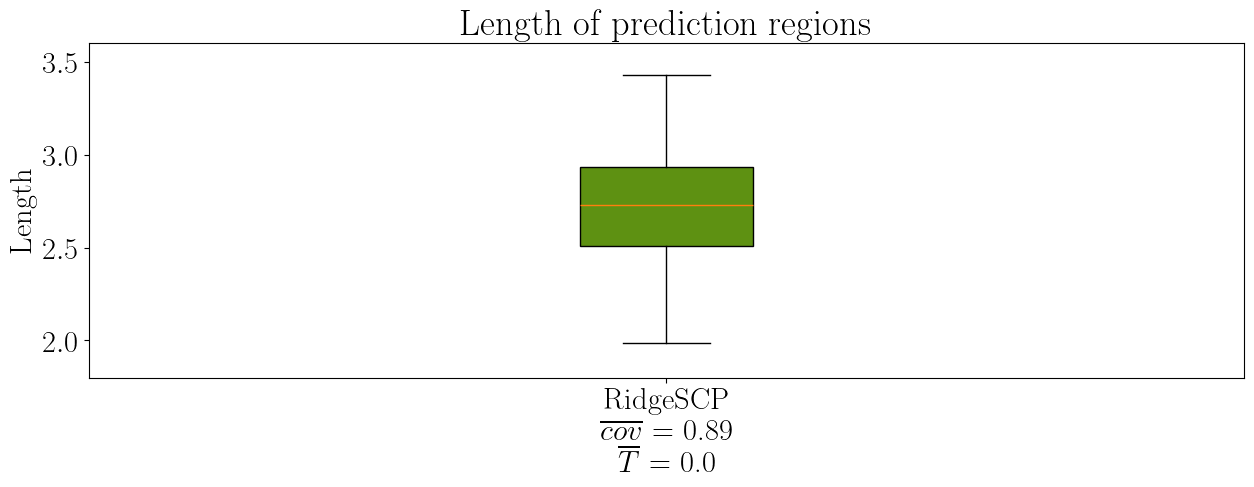

In [30]:
colors = ["#5E9112"]
labels = []
labels += [labelize("RidgeSCP", coverages, compute_time)]

fig, ax = plt.subplots(figsize=(13,5))
box = ax.boxplot(prediction_region_sizes, patch_artist=True)
ax.set_ylabel("Length")
# plt.title(method + " : " + dataset)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.grid(False)
ax.set_xticks(np.arange(1, len(labels) + 1), labels)
ax.set_ylim(1.8, 3.6)
fig.tight_layout()
ax.set_title("Length of prediction regions")